# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Curvature penalized models

In this notebook, we solve non-holonomic eikonal equations on the CPU and GPU, related to curvature penalized models.
Our purpose is to establish that the schemes produce consistent results.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU,RunSmart,Metrics
    HFMUtils,ad,cugen,Metrics = rreload([HFMUtils,ad,cugen,Metrics],"../..")    
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

## 1. Reeds-Shepp

In [20]:
ReloadPackages()

In [30]:
n=300; nTheta=96
hfmIn = HFMUtils.dictIn({
    'model':'Dubins2',
    'seeds':cp.array([[0.,0.,np.pi]]),
    'exportValues':1,
    'cost':1,
    'xi':0.4,
    'tol':3e-6,
    'count_updates':True,
#    'nitermax_o':1,
    'traits':{'niter_i':1,
             'shape_i':(4,4,2),
             'nFejer_macro':5,
             'OffsetT':np.int32,
#              'network_sort_macro':1,
              #'merge_sort_macro':1,
             },
#    'bound_active_blocks':True,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['dims'] = np.append(hfmIn['dims'],nTheta)
        
tips = hfmIn.Grid(dims=(4,4,4))
tips = np.moveaxis(tips.reshape(3,-1),0,-1)
hfmIn['tips'] = tips

Casting output of function array from float64 to float32


In [32]:
hfmOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.35998010635375977 seconds,  and 204 iterations.
Post-Processing


In [10]:
hfmOut_divide=hfmOut.copy()

In [12]:
hfmOut_bubble=hfmOut.copy()

In [15]:
np.nanmin(hfmOut_divide['values']-hfmOut_bubble['values'])

array(-0.00042, dtype=float32)

In [286]:
np.nanmin(hfmOut5['values']-hfmOut2['values'])
#hfmOut5['scheme_weights']

array(-0.000189304352, dtype=float32)

In [141]:
hfmOut['keys']['default']['tol']

3.3338267e-08

In [241]:
np.mean(hfmOut['stats']['eikonal']['nupdate_o'])

array(42.3557032)

In [244]:
np.mean(hfmOut['stats']['eikonal']['nupdate_o'])

array(144.466629)

In [149]:
np.mean(hfmOut['stats']['eikonal']['nupdate_o'])

array(42.3474002)

In [97]:
np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%5.9g" % x))

def cos_sin_table(n): 
    angles = (np.arange(n)+0.5)*np.pi/n
    return np.cos(angles),np.sin(angles)
cos_sin_table(4)

(array([0.923879533, 0.382683432, -0.382683432, -0.923879533]),
 array([0.382683432, 0.923879533, 0.923879533, 0.382683432]))

In [57]:
np.mean(hfmOut['stats']['eikonal']['nupdate_o'])

array( 23.4)

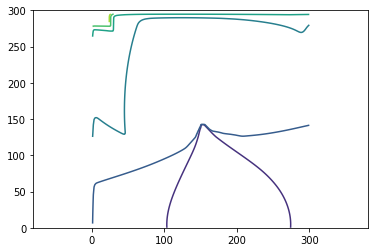

In [10]:
plt.axis('equal')
plt.contour(hfmOut['values'][:,:,40])

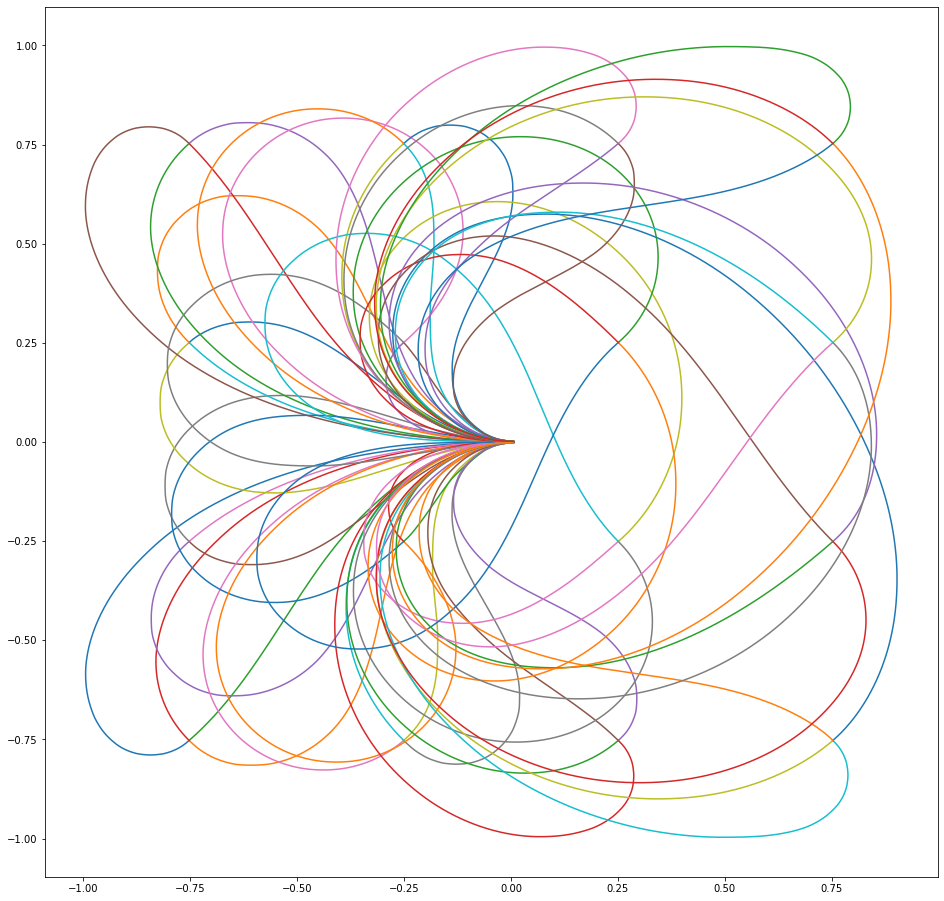

In [11]:
plt.figure(figsize=[16,16])
for geo in hfmOut['geodesics']: plt.plot(geo[0],geo[1])

In [12]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 2.59648060798645 seconds,  and 187 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 88.664 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
***** Warning ! *****
Unused fields from user: count_updates tol 
********************
Solver time (s). GPU : 2.59648060798645, CPU : 88.749. Device acceleration : 34.18049791206572
Max |gpuValues-cpuValues| :  2.0736749771355836


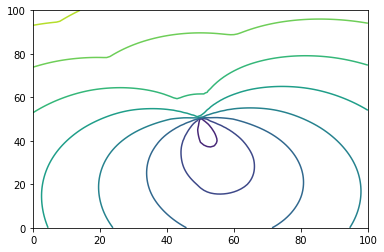

In [54]:
plt.contour(cpuOut['values'][:,:,40])

In [55]:
cpuSlice = cpuOut['values'][:,:,40]
gpuSlice = gpuOut['values'][:,:,40]
np.min(cpuSlice),np.min(gpuSlice)

(0.20943951023931956, array(0.209, dtype=float32))

In [13]:
cpuVal = cpuOut['values'].copy()
gpuVal = gpuOut['values'].copy()
cpuPos = np.isinf(cpuVal)
gpuPos = np.isinf(gpuVal)
print("differing infs ? ",np.any(np.logical_xor(cpuPos,gpuPos.get())))

differing infs ?  False


In [57]:
np.sum(gpuPos)

array(0)

In [58]:
np.max(np.abs(cpuVal-gpuVal.get()))

0.167898324662071

In [14]:
np.sum(np.abs(cpuVal-gpuVal.get())>0.01)/cpuVal.size

C:\Users\Shadow\Miniconda3\envs\gpuenv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
C:\Users\Shadow\Miniconda3\envs\gpuenv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.07932411066103023

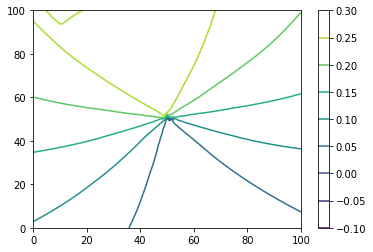

In [51]:
plt.contour(cpuSlice-gpuSlice.get()); plt.colorbar()

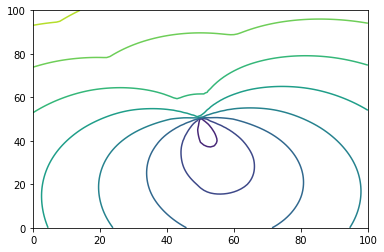

In [52]:
plt.contour(cpuSlice)

## 2. Reeds-Shepp forward

In [17]:
n=20; nTheta=60
hfmIn = HFMUtils.dictIn({
    'model':'ReedsSheppForward2',
    'seeds':cp.array([[0.,0.,np.pi]]),
    'exportValues':1,
    'cost':1,
    'xi':0.2,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['dims'] = np.append(hfmIn['dims'],nTheta)

Casting output of function array from float64 to float32


In [18]:
RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)


ValueError: Inconsistent type <class 'numpy.object_'> for key geom

In [ ]:
np.append